# Impact of U.S. Immigration Policy Changes on Juvenile Immigrants: A Data-Driven Analysis

## Research Question
**How do changes in U.S. immigration policy under different administrations affect access to legal representation and outcomes for immigrant juveniles seeking protection?**

This analysis investigates how policy changes between 2018 and 2025 shaped access to legal representation and case outcomes for immigrant juveniles in U.S. immigration courts.

### Analysis Approach

The analysis framework consists of three methods:

1. **Time Series Analysis**: Tracking changes across different administration periods (2018-2025)
2. **Chi-square Tests**: Examining relationships between legal representation and case outcomes
3. **Logistic Regression**: Determining features most predictive of favorable case outcomes

In [2]:
!pip install -U statsmodels -q

In [3]:
import os

from IPython.display import Markdown, display
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

plt.style.use("fivethirtyeight")
sns.set_palette("deep")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

## 1. Data Loading and Preparation

The following tables are used in this analysis:

**Cleaned Case Data**  
- `juvenile_history_cleaned.csv` – Contains links between case records, proceedings, and representation details  
- `juvenile_cases_cleaned.csv` – Contains core case information at the juvenile level  
- `juvenile_reps_assigned_cleaned.csv` – Contains records of legal representation assigned to juveniles  
- `juvenile_proceedings_cleaned.csv` – Contains proceedings data, including decisions and absentia status  

**Reference Tables**  
- `tblLookup_Juvenile.csv` – Provides category definitions for juvenile case types  
- `tblDecCode.csv` – Provides descriptions for decision codes  

The first four tables represent **cleaned, analysis-ready inputs** prepared in earlier stages. The reference tables serve as **lookups for categorical values**, enabling interpretation of codes used in the main datasets.  

In [12]:
juvenile_history_path = "../data/cleaned/juvenile_history_cleaned.csv.gz"
juvenile_cases_path = "../data/cleaned/juvenile_cases_cleaned.csv.gz"
juvenile_reps_assigned_path = "../data/cleaned/juvenile_reps_assigned_cleaned.csv.gz"
juvenile_proceedings_path = "../data/cleaned/juvenile_proceedings_cleaned.csv.gz"
lookup_juvenile_path = "../data/raw/tblLookup_Juvenile.csv"
lookup_decision_path = "../data/raw/tblDecCode.csv"

In [5]:
def load_table(path, dtype=None, parse_dates=None):
    """
    Load a CSV file into a DataFrame with optional dtypes and date parsing.

    Parameters
    ----------
    path : str
        Path to the CSV file.
    dtype : dict, optional
        Column type mappings to enforce during load.
    parse_dates : list, optional
        Columns to parse as datetime. Null or invalid values are coerced to NaT.

    Returns
    -------
    DataFrame
        Cleaned DataFrame with specified types and datetime columns standardized.
    """
    df = pd.read_csv(path, dtype=dtype, parse_dates=parse_dates, low_memory=False)
    if parse_dates:
        for col in parse_dates:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors="coerce")
    return df

In [6]:
juvenile_history_dtype = {
    "idnJuvenileHistory": "Int64",
    "idnCase": "Int64",
    "idnProceeding": "Int64",
    "idnJuvenile": "category",
}

juvenile_history = load_table(
    path=juvenile_history_path,
    dtype=juvenile_history_dtype
)

In [7]:
juvenile_history.dtypes

idnJuvenileHistory       Int64
idnCase                  Int64
idnProceeding            Int64
idnJuvenile           category
dtype: object

In [ ]:
juvenile_cases_dtype = {
    "IDNCASE": "Int64",
    "NAT": "category",
    "LANG": "category",
    "CUSTODY": "category",
    "CASE_TYPE": "category",
    "LATEST_CAL_TYPE": "category",
    "Sex": "category",
}

juvenile_cases_parse_dates = [
    "LATEST_HEARING",
    "DATE_OF_ENTRY",
    "C_BIRTHDATE",
    "DATE_DETAINED",
    "DATE_RELEASED",
]

juvenile_cases = load_table(
    path=juvenile_cases_path,
    dtype=juvenile_cases_dtype,
    parse_dates=juvenile_cases_parse_dates
)

In [9]:
juvenile_cases.dtypes

IDNCASE                     Int64
NAT                      category
LANG                     category
CUSTODY                  category
CASE_TYPE                category
LATEST_HEARING     datetime64[ns]
LATEST_CAL_TYPE          category
DATE_OF_ENTRY      datetime64[ns]
C_BIRTHDATE        datetime64[ns]
Sex                      category
DATE_DETAINED      datetime64[ns]
DATE_RELEASED      datetime64[ns]
dtype: object

In [119]:
juvenile_reps_assigned_dtype = {
    "IDNREPSASSIGNED": "Int64",
    "IDNCASE": "Int64",
    "STRATTYLEVEL": "category",
    "STRATTYTYPE": "category",
}

juvenile_reps_parse_dates = ["E_28_DATE"]

juvenile_reps_assigned = load_table(
    path=juvenile_reps_assigned_path,
    dtype=juvenile_reps_assigned_dtype,
    parse_dates=juvenile_reps_parse_dates
)

In [11]:
juvenile_reps_assigned.dtypes

IDNREPSASSIGNED             Int64
IDNCASE                     Int64
STRATTYLEVEL             category
STRATTYTYPE              category
E_28_DATE          datetime64[ns]
dtype: object

In [43]:
juvenile_proceedings_dtype = {
    "IDNPROCEEDING": "Int64",
    "IDNCASE": "Int64",
    "BASE_CITY_CODE": "category",
    "HEARING_LOC_CODE": "category",
    "DEC_CODE": "category",
    "ABSENTIA": "category",
    "CRIM_IND": "category",
    "NAT": "category",
    "LANG": "category",
    "CASE_TYPE": "category",
    "CUSTODY": "category",
}

juvenile_proceedings_parse_dates = [
    "OSC_DATE",
    "INPUT_DATE",
    "COMP_DATE",
    "DATE_DETAINED",
    "DATE_RELEASED",
]

juvenile_proceedings = load_table(
    path=juvenile_proceedings_path,
    dtype=juvenile_proceedings_dtype,
    parse_dates=juvenile_proceedings_parse_dates
)

In [14]:
juvenile_proceedings.dtypes

IDNPROCEEDING                Int64
IDNCASE                      Int64
OSC_DATE            datetime64[ns]
INPUT_DATE          datetime64[ns]
BASE_CITY_CODE            category
HEARING_LOC_CODE          category
DEC_CODE                  category
COMP_DATE           datetime64[ns]
ABSENTIA                  category
CUSTODY                   category
CASE_TYPE                 category
NAT                       category
LANG                      category
CRIM_IND                  category
DATE_DETAINED       datetime64[ns]
DATE_RELEASED       datetime64[ns]
dtype: object

In [16]:
lookup_juvenile_dtype = {
    "idnJuvenile": "category",
    "strCode": "category",
    "strDescription": "category"
}

lookup_juvenile_usecols = {
    "idnJuvenile",
    "strCode",
    "strDescription",
}

lookup_juvenile = pd.read_csv(
    filepath_or_buffer=lookup_juvenile_path,
    delimiter="\t",
    usecols=lookup_juvenile_usecols,
    dtype=lookup_juvenile_dtype
)

In [19]:
lookup_decisions_dtype = {
    "idnDecCode": "category",
    "strCode": "category",
    "strDescription": "category",
}

lookup_decisions_usecols = {
    "idnDecCode",
    "strCode",
    "strDescription",
}

lookup_decisions = pd.read_csv(
    filepath_or_buffer=lookup_decision_path,
    delimiter="\t",
    usecols=lookup_decisions_usecols,
    dtype=lookup_decisions_dtype,
)

In [24]:
# Display the data types for all tables
display(Markdown("### Data Types for All Tables"))

tables = {
    "Juvenile History": juvenile_history,
    "Cases": juvenile_cases,
    "Reps Assigned": juvenile_reps_assigned,
    "Proceedings": juvenile_proceedings,
    "Lookup Juvenile": lookup_juvenile,
    "Lookup Decision": lookup_decisions,
}

for name, df in tables.items():
    display(
        Markdown(
            f"**{name} Data Types**  \n"
            f"- Shape: {df.shape[0]:,} rows × {df.shape[1]:,} columns"
        )
    )
    display(df.dtypes.to_frame("dtype"))

### Data Types for All Tables

**Juvenile History Data Types**  
- Shape: 2,876,040 rows × 4 columns

,dtype
idnJuvenileHistory,Int64
idnCase,Int64
idnProceeding,Int64
idnJuvenile,category


**Cases Data Types**  
- Shape: 1,923,172 rows × 12 columns

,dtype
IDNCASE,Int64
NAT,category
LANG,category
CUSTODY,category
CASE_TYPE,category
LATEST_HEARING,datetime64[ns]
LATEST_CAL_TYPE,category
DATE_OF_ENTRY,datetime64[ns]
C_BIRTHDATE,datetime64[ns]
Sex,category


**Reps Assigned Data Types**  
- Shape: 2,580,448 rows × 5 columns

,dtype
IDNREPSASSIGNED,Int64
IDNCASE,Int64
STRATTYLEVEL,category
STRATTYTYPE,category
E_28_DATE,datetime64[ns]


**Proceedings Data Types**  
- Shape: 2,819,051 rows × 16 columns

,dtype
IDNPROCEEDING,Int64
IDNCASE,Int64
OSC_DATE,datetime64[ns]
INPUT_DATE,datetime64[ns]
BASE_CITY_CODE,category
HEARING_LOC_CODE,category
DEC_CODE,category
COMP_DATE,datetime64[ns]
ABSENTIA,category
CUSTODY,category


**Lookup Juvenile Data Types**  
- Shape: 6 rows × 3 columns

,dtype
idnJuvenile,category
strCode,category
strDescription,category


**Lookup Decision Data Types**  
- Shape: 12 rows × 3 columns

,dtype
idnDecCode,category
strCode,category
strDescription,category


## 2. Data Overview and Inspection

The structure and content of the datasets are examined to better understand the available information and prepare for subsequent analysis.

In [32]:
display(Markdown("### Juvenile History Sample"))
display(juvenile_history.head(3))

### Juvenile History Sample

,idnJuvenileHistory,idnCase,idnProceeding,idnJuvenile
0,5,2046990,3200129,1
1,6,2047179,3199488,1
2,7,2047179,3199489,1


In [33]:
display(Markdown("### Juvenile Cases Sample"))
display(juvenile_cases.head(3))

### Juvenile Cases Sample

,IDNCASE,NAT,LANG,CUSTODY,CASE_TYPE,LATEST_HEARING,LATEST_CAL_TYPE,DATE_OF_ENTRY,C_BIRTHDATE,Sex,DATE_DETAINED,DATE_RELEASED
0,6807609,MX,SP,D,RMV,2021-07-19,M,NaT,NaT,NaN,2020-02-03,NaT
1,6807621,TZ,SWA,D,RMV,NaT,NaN,NaT,NaT,NaN,2011-09-27,NaT
2,6807631,HO,SP,D,RMV,NaT,NaN,2011-07-01,NaT,NaN,2011-10-19,NaT


In [34]:
display(Markdown("### Reps Assigned Sample:"))
display(juvenile_reps_assigned.head(3))

### Reps Assigned Sample:

,IDNREPSASSIGNED,IDNCASE,STRATTYLEVEL,STRATTYTYPE,E_28_DATE
0,5947072,2607017,COURT,ALIEN,2004-09-23
1,5947352,2848551,COURT,ALIEN,1991-10-29
2,5948254,2824744,COURT,ALIEN,1999-06-25


In [36]:
display(Markdown("### Proceedings Sample:"))
display(juvenile_proceedings.head(3))

### Proceedings Sample:

,IDNPROCEEDING,IDNCASE,OSC_DATE,INPUT_DATE,BASE_CITY_CODE,HEARING_LOC_CODE,DEC_CODE,COMP_DATE,ABSENTIA,CUSTODY,CASE_TYPE,NAT,LANG,CRIM_IND,DATE_DETAINED,DATE_RELEASED
0,9329335,9431121,2019-12-22,2020-01-31,CHL,CHL,NaN,NaT,NaN,N,RMV,MX,SP,N,NaT,NaT
1,9329336,9431122,2019-12-22,2020-01-31,CHL,CHL,NaN,NaT,NaN,N,RMV,MX,SP,N,NaT,NaT
2,9329337,9431123,2019-12-22,2020-01-31,CHL,CHL,NaN,NaT,NaN,N,RMV,MX,SP,N,NaT,NaT


In [37]:
display(Markdown("### Lookup Juvenile Data:"))
display(lookup_juvenile)

### Lookup Juvenile Data:

,idnJuvenile,strCode,strDescription
0,1,J,Juvenile Case
1,2,J1,Juvenile has been released to guardian or has ...
2,3,J2,Unaccompanied Juvenile - Asylum
3,4,UJ,Unaccompanied Juvenile
4,5,NaN,Not Applicable
5,6,AJ,Accompanied Juvenile


In [38]:
display(Markdown("### Lookup Decision Codes:"))
display(lookup_decisions)

### Lookup Decision Codes:

,idnDecCode,strCode,strDescription
0,1,A,LEGALLY ADMITTED
1,2,C,CONDITIONAL GRANT
2,3,D,DEPORTED
3,4,E,EXCLUDED
4,5,G,GRANTED
5,6,O,OTHER
6,7,R,RELIEF/RESCINDED
7,8,S,ALIEN MAINTAINS LEGAL STATUS
8,9,T,CASE TERMINATED BY IJ
9,10,V,VOLUNTARY DEPARTURE


The datasets together provide a structured view of juvenile immigration cases, each contributing a distinct analytical dimension. The **Juvenile History** table serves as a junction, linking juveniles, cases, and proceedings for integrated analysis. The **Cases** dataset contains demographic attributes and key temporal markers (e.g., entry, custody, release, hearings), forming the primary feature set for modeling. The **Reps Assigned** dataset encodes representation details, capturing attorney type and level, which are essential for evaluating the role of legal aid. The **Proceedings** dataset records hearing-level information, including decision codes and *in absentia* status, which define case outcomes.

A critical component of the analysis is the **distribution of decision codes**, as these operationalize the outcome variable. Mapping decision patterns against demographic, procedural, and representation features enables robust statistical testing and predictive modeling of case outcomes.

In [44]:
dist_counts = juvenile_proceedings["DEC_CODE"].value_counts(dropna=False)
dist_perc = (
    juvenile_proceedings["DEC_CODE"].value_counts(normalize=True, dropna=False) * 100
)

dist_summary = (
    pd.DataFrame({"Count": dist_counts, "Percentage": dist_perc})
    .reset_index()
    .rename(columns={"index": "DEC_CODE"})
)

display(Markdown("### Decision Code Distribution"))
display(dist_summary.head(20))

### Decision Code Distribution

,DEC_CODE,Count,Percentage
0,NaN,1340305,47.544546
1,X,712195,25.263644
2,U,284771,10.101662
3,T,183240,6.500060
4,V,105445,3.740443
5,A,84170,2.985757
6,R,82231,2.916975
7,D,11935,0.423369
8,W,5522,0.195882
9,G,2843,0.100850


### Interpreting Missing Values in `DEC_CODE`

A substantial share of proceedings (≈47%) have a `NaN` value for `DEC_CODE`.  
This can occur for a few reasons:

- **Decision not yet made** – the proceeding was recorded, but no outcome was entered at the time.  
- **Data entry gaps** – less common, but possible if the decision field was left blank or not properly filled.  
- **Administrative placeholders** – in some cases, missing values may simply indicate that a decision was not applicable for that proceeding type.

Because these `NaN` values represent a large portion of the data, they need to be interpreted carefully in subsequent analysis. In practice, they are treated as “no decision recorded,” but it is important to recognize that this category may mix true pending decisions with data quality issues.

## 3. Data Preparation and Integration

To create a unified dataset for analysis, the following integration steps are applied:

- **Merge juvenile cases with proceedings** to attach decision codes to each case record.  
- **Merge with representation assignments** to incorporate information on whether and how juveniles were legally represented.  
- **Join with the decision code lookup table** to enrich categorical outcomes with human-readable descriptions, making downstream analysis and interpretation more transparent.

In [ ]:
# The following table reports missing values in key identifiers and decision codes across datasets

checks = {
    "juvenile_cases IDNCASE": (juvenile_cases["IDNCASE"], len(juvenile_cases)),
    "juvenile_proceedings IDNCASE": (
        juvenile_proceedings["IDNCASE"],
        len(juvenile_proceedings),
    ),
    "juvenile_reps_assigned IDNCASE": (
        juvenile_reps_assigned["IDNCASE"],
        len(juvenile_reps_assigned),
    ),
    "juvenile_proceedings DEC_CODE": (
        juvenile_proceedings["DEC_CODE"],
        len(juvenile_proceedings),
    ),
}

for name, (series, total) in checks.items():
    missing_count = series.isna().sum()
    missing_pct = (missing_count / total) * 100
    print(f"{name}: {missing_count} missing ({missing_pct:.2f}%)")

juvenile_cases IDNCASE: 0 missing (0.00%)
juvenile_proceedings IDNCASE: 0 missing (0.00%)
juvenile_reps_assigned IDNCASE: 0 missing (0.00%)
juvenile_proceedings DEC_CODE: 1340305 missing (47.54%)


### Adding Decision Descriptions

The `DEC_CODE` column in the `juvenile_proceedings` table is mapped to its corresponding human-readable description from the lookup table.  
This step improves interpretability of decision outcomes in summaries and visualizations.  
The description column is stored as `category` to optimize memory usage.

In [68]:
juvenile_proceedings_selected_columns = [
    "IDNCASE",
    "COMP_DATE",
    "DEC_CODE",
]

# Keep only columns relevant for analysis
proceedings_sel = juvenile_proceedings[juvenile_proceedings_selected_columns].copy()

# Map decision codes to human-readable descriptions
dec_map = dict(zip(lookup_decisions["strCode"], lookup_decisions["strDescription"]))
proceedings_sel["DEC_DESC"] = proceedings_sel["DEC_CODE"].map(dec_map)

proceedings_sel["DEC_DESC"] = proceedings_sel["DEC_DESC"].astype("category")

proceedings_with_decisions = proceedings_sel

In [69]:
proceedings_with_decisions.head()

,IDNCASE,COMP_DATE,DEC_CODE,DEC_DESC
0,9431121,NaT,NaN,NaN
1,9431122,NaT,NaN,NaN
2,9431123,NaT,NaN,NaN
3,9431124,2020-02-24,X,REMOVED
4,9431125,NaT,NaN,NaN


### Dataset Integration

A unified dataset is constructed by merging three sources:

1. **Cases × Proceedings**  
   - Merge `juvenile_cases` with `proceedings_with_decisions` on `IDNCASE`.  
   - Retain only key identifiers, demographics, birth/hearing dates, and decision details.  

2. **Add Representation**  
   - Drop duplicate `IDNCASE` entries in `juvenile_reps_assigned` (keep first) to avoid one-to-many expansion.  
   - Merge the resulting table with the cases–proceedings dataset on `IDNCASE`.  
   - Standardize representation levels:  
     - Add `"no_representation"` as a valid category.  
     - Fill missing values with `"no_representation"`.  
     - Rename `STRATTYLEVEL` → `REPRESENTATION_LEVEL`.  

In [161]:
juvenile_cases_cols = [
    "IDNCASE",
    "NAT",
    "LANG",
    "CASE_TYPE",
    "Sex",
    "C_BIRTHDATE",
    "LATEST_HEARING",
]

cases_sel = juvenile_cases[juvenile_cases_cols].copy()

merged_data = cases_sel.merge(
    proceedings_with_decisions,
    left_on="IDNCASE",
    right_on="IDNCASE",
    how="left"
)

In [162]:
# Drop duplicate case entries (keep the first record per case)
juvenile_reps_assigned = juvenile_reps_assigned.drop_duplicates(
    subset=["IDNCASE"], keep="first"
)

# Merge with reps_assigned (only relevant column)
merged_data = merged_data.merge(
    juvenile_reps_assigned[["IDNCASE", "STRATTYLEVEL"]], on="IDNCASE", how="left"
)

# Handle missing representation values
merged_data["STRATTYLEVEL"] = (
    merged_data["STRATTYLEVEL"]
    .cat.add_categories(["no_representation"])
    .fillna("no_representation")
)

merged_data = merged_data.rename(columns={"STRATTYLEVEL": "REPRESENTATION_LEVEL"})

In [163]:
print("Sample rows from merged dataset:")
display(merged_data.head())

Sample rows from merged dataset:


,IDNCASE,NAT,LANG,CASE_TYPE,Sex,C_BIRTHDATE,LATEST_HEARING,COMP_DATE,DEC_CODE,DEC_DESC,REPRESENTATION_LEVEL
0,6807609,MX,SP,RMV,NaN,NaT,2021-07-19,2020-06-10,X,REMOVED,COURT
1,6807609,MX,SP,RMV,NaN,NaT,2021-07-19,2011-10-19,NaN,NaN,COURT
2,6807609,MX,SP,RMV,NaN,NaT,2021-07-19,2020-02-11,NaN,NaN,COURT
3,6807621,TZ,SWA,RMV,NaN,NaT,NaT,2011-09-27,NaN,NaN,COURT
4,6807621,TZ,SWA,RMV,NaN,NaT,NaT,2012-09-11,T,CASE TERMINATED BY IJ,COURT


In [166]:
merged_data["REPRESENTATION_LEVEL"].value_counts()

REPRESENTATION_LEVEL
COURT                1652901
no_representation    1163706
Name: count, dtype: int64

## 4. Data Enhancement

Derived fields were engineered to improve the analytical value of the dataset:

1. **Age at Filing (`AGE_AT_FILING`)**  
   - Computed from `C_BIRTHDATE` and `hearing_date_combined` (which prioritizes `COMP_DATE`, falling back to `LATEST_HEARING`).  
   - Unrealistic ages (outside 0–21 years) arise from synthetic or inconsistent dates and are set to `NaN` instead of being dropped.  
   - Remaining ages are rounded and stored as nullable integers (`Int64`).

2. **Language Indicator (`LANG_IS_ENGLISH`)**  
   - Binary flag based on `LANG`:  
     - `ENG` - 1 (English)  
     - Any other value - 0 (Non-English)

3. **Legal Representation (`HAS_LEGAL_REP`)**  
   - Derived from `REPRESENTATION_LEVEL`:  
     - `COURT` or `BOARD` - **Has Legal Representation**  
     - `no_representation` - **No Legal Representation**  
     - Any other value - **Unknown**

4. **Policy Era (`POLICY_ERA`)**  
   - Categorized by major immigration policy phases:  
     - *Trump Era I* (2018-04-06 – 2021-01-19)  
     - *Biden Era* (2021-01-20 – 2025-03-31)  
     - *Trump Era II* (2025-04-01 – present)  
   - Records with missing dates are labeled **other**.

5. **Outcome Buckets**  
   - Decision codes (`DEC_CODE`) will be grouped into **Favorable**, **Unfavorable**, or **Other** for downstream analysis and modeling.

In [165]:
def calculate_age(birthdate, hearing_date):
    if pd.isna(birthdate) or pd.isna(hearing_date):
        return None
    return (hearing_date - birthdate).days / 365.25


merged_data["hearing_date_combined"] = merged_data["COMP_DATE"].fillna(
    merged_data["LATEST_HEARING"]
)

merged_data["AGE_AT_FILING"] = merged_data.apply(
    lambda row: calculate_age(row["C_BIRTHDATE"], row["hearing_date_combined"]), axis=1
)

# Due to **synthetic data and missing/inconsistent dates**, some records yield unrealistic ages
# Instead of dropping these records, ages outside the valid juvenile range (0–21 years) are set to `NaN`
merged_data.loc[
    (merged_data["AGE_AT_FILING"] < 0) | (merged_data["AGE_AT_FILING"] > 21),
    "AGE_AT_FILING",
] = np.nan

merged_data["AGE_AT_FILING"] = merged_data["AGE_AT_FILING"].round().astype("Int64")

In [167]:
merged_data["LANG_IS_ENGLISH"] = (
    merged_data["LANG"]
    .apply(lambda x: 1 if str(x).strip().upper() == "ENG" else 0)
    .astype("Int64")
)

In [169]:
def determine_policy_era(date):
    if pd.isna(date):
        return "Other"

    if pd.Timestamp("2018-04-06") <= date < pd.Timestamp("2021-01-20"):
        return "Trump Era I (Apr 2018 – Jan 2021)"
    elif pd.Timestamp("2021-01-20") <= date < pd.Timestamp("2025-04-01"):
        return "Biden Era (Jan 2021 – Apr 2025)"
    elif date >= pd.Timestamp("2025-04-01"):
        return "Trump Era II (Apr 2025 – Present)"
    else:
        return "Other"


# Determine policy era
merged_data["POLICY_ERA"] = merged_data["hearing_date_combined"].apply(
    determine_policy_era
)

In [171]:
merged_data["HAS_LEGAL_REP"] = merged_data["REPRESENTATION_LEVEL"].apply(
    lambda x: (
        "No Legal Representation"
        if x == "no_representation"
        else ("Has Legal Representation" if x == "COURT" or x == "BOARD" else "Unknown")
    )
)

In [172]:
print("=== Summary of Available Data ===")
print(f"Total records: {len(merged_data):,}")
print(
    f"Records with valid age calculation: {merged_data['AGE_AT_FILING'].notna().sum():,}"
)

print("\n--- Policy Era Distribution ---")
print(merged_data["POLICY_ERA"].value_counts().to_string())

print("\n--- Legal Representation Distribution ---")
print(merged_data["HAS_LEGAL_REP"].value_counts().to_string())

print("\n--- Language Distribution (ENG vs NON-ENG) ---")
print(merged_data["LANG_IS_ENGLISH"].value_counts().to_string())

=== Summary of Available Data ===
Total records: 2,816,607
Records with valid age calculation: 892,081

--- Policy Era Distribution ---
POLICY_ERA
Biden Era (Jan 2021 – Apr 2025)      1269267
Trump Era I (Apr 2018 – Jan 2021)     608788
Other                                 511876
Trump Era II (Apr 2025 – Present)     426676

--- Legal Representation Distribution ---
HAS_LEGAL_REP
Has Legal Representation    1652901
No Legal Representation     1163706

--- Language Distribution (ENG vs NON-ENG) ---
LANG_IS_ENGLISH
0    2692966
1     121760


In [173]:
# Define outcome categories
favorable_decisions = {"A", "C", "G", "R", "S", "T"}  # favorable for the juvenile
unfavorable_decisions = {"D", "E", "V", "X"}  # unfavorable
other_decisions = {"O", "W"}  # ambiguous or unclear


def categorize_outcome(dec_code):
    """Categorize decision codes into Favorable, Unfavorable, Other, or Unknown."""
    if pd.isna(dec_code):
        return "Unknown"
    elif dec_code in favorable_decisions:
        return "Favorable"
    elif dec_code in unfavorable_decisions:
        return "Unfavorable"
    elif dec_code in other_decisions:
        return "Other"
    else:
        return "Other"  # fallback for unexpected codes


# Apply categorization
merged_data["BINARY_OUTCOME"] = merged_data["DEC_CODE"].apply(categorize_outcome)

# Preserve descriptive text for clarity
merged_data["CASE_OUTCOME"] = merged_data['DEC_DESC']

In [174]:
merged_data.columns

Index(['IDNCASE', 'NAT', 'LANG', 'CASE_TYPE', 'Sex', 'C_BIRTHDATE',
       'LATEST_HEARING', 'COMP_DATE', 'DEC_CODE', 'DEC_DESC',
       'REPRESENTATION_LEVEL', 'hearing_date_combined', 'AGE_AT_FILING',
       'LANG_IS_ENGLISH', 'POLICY_ERA', 'HAS_LEGAL_REP', 'BINARY_OUTCOME',
       'CASE_OUTCOME'],
      dtype='object')

In [175]:
analysis_columns = [
    "AGE_AT_FILING",
    "Sex",
    "LANG_IS_ENGLISH",
    "hearing_date_combined",
    "POLICY_ERA",
    "HAS_LEGAL_REP",
    "DEC_CODE",
    "CASE_OUTCOME",
    "BINARY_OUTCOME",
]

analysis_df = merged_data[analysis_columns].copy()

analysis_df.columns = analysis_df.columns.str.upper()

In [176]:
print("First 5 rows of analysis dataset (standardized):")
display(analysis_df.head())

First 5 rows of analysis dataset (standardized):


,AGE_AT_FILING,SEX,LANG_IS_ENGLISH,HEARING_DATE_COMBINED,POLICY_ERA,HAS_LEGAL_REP,DEC_CODE,CASE_OUTCOME,BINARY_OUTCOME
0,<NA>,NaN,0,2020-06-10,Trump Era I (Apr 2018 – Jan 2021),Has Legal Representation,X,REMOVED,Unfavorable
1,<NA>,NaN,0,2011-10-19,Other,Has Legal Representation,NaN,NaN,NaN
2,<NA>,NaN,0,2020-02-11,Trump Era I (Apr 2018 – Jan 2021),Has Legal Representation,NaN,NaN,NaN
3,<NA>,NaN,0,2011-09-27,Other,Has Legal Representation,NaN,NaN,NaN
4,<NA>,NaN,0,2012-09-11,Other,Has Legal Representation,T,CASE TERMINATED BY IJ,Favorable


### Case Outcome Classification

Case outcomes were categorized into **Favorable** and **Unfavorable** groups based on their legal implications for juvenile immigrants:

- **Favorable**: Outcomes that provide continued legal presence or a pathway to permanent residency (e.g., asylum grants, SIJS approvals, T/U visas).  
- **Unfavorable**: Outcomes that result in removal orders, voluntary departures, or case terminations without legal status.  

This binary classification simplifies statistical modeling while preserving the critical distinction between outcomes that offer legal protection and those that do not. The categorization follows standard practices in immigration policy research.

In [177]:
print("\n=== Distribution of Key Variables ===")

print("\n--- Legal Representation ---")
print(analysis_df["HAS_LEGAL_REP"].value_counts(dropna=False).to_string())

print("\n--- Case Outcomes (Binary) ---")
print(analysis_df["BINARY_OUTCOME"].value_counts(dropna=False).to_string())

print("\n--- Policy Era ---")
print(analysis_df["POLICY_ERA"].value_counts(dropna=False).to_string())


=== Distribution of Key Variables ===

--- Legal Representation ---
HAS_LEGAL_REP
Has Legal Representation    1652901
No Legal Representation     1163706

--- Case Outcomes (Binary) ---
BINARY_OUTCOME
NaN            1338993
Unfavorable     830468
Favorable       352188
Other           294958

--- Policy Era ---
POLICY_ERA
Biden Era (Jan 2021 – Apr 2025)      1269267
Trump Era I (Apr 2018 – Jan 2021)     608788
Other                                 511876
Trump Era II (Apr 2025 – Present)     426676


## 5. Legal Representation, Case Outcomes, and Policy Era Analysis

This section examines how legal representation, case outcomes, and policy eras interact in shaping the experiences of juvenile immigrants.  
The analysis considers three pairwise relationships:  

- **Legal Representation vs. Case Outcomes**  
- **Legal Representation vs. Policy Era**  
- **Case Outcomes vs. Policy Era**  

To ensure meaningful comparisons, cases are restricted to those with:  
- A known representation status (excluding "Unknown")  
- A clear binary outcome (excluding "Unknown" or "Other")  
- Assignment to a defined policy era (excluding "Other")  

After filtering, cross-tabulations and visualizations are used to compare distributions across groups and assess how these factors influence the likelihood of favorable outcomes. This approach highlights whether access to legal counsel, shifts in policy environments, or both are most strongly associated with case results for juveniles.

In [178]:
# Count rows before filtering
before_count = len(analysis_df)

# Apply filtering
analysis_filtered = analysis_df[
    (analysis_df["HAS_LEGAL_REP"] != "Unknown")
    & (analysis_df["BINARY_OUTCOME"] != "Unknown")
    & (analysis_df["BINARY_OUTCOME"] != "Other")
    & (analysis_df["BINARY_OUTCOME"].notna())
    & (analysis_df["POLICY_ERA"] != "Other")
].copy()

# Count rows after filtering
after_count = len(analysis_filtered)
dropped_count = before_count - after_count
dropped_pct = (dropped_count / before_count) * 100

# Check the distribution of cases after filtering
print("Legal representation distribution (filtered dataset):")
rep_counts = analysis_filtered["HAS_LEGAL_REP"].value_counts()
print(rep_counts)

# Calculate overall representation rate
rep_rate = rep_counts["Has Legal Representation"] / after_count * 100
print(f"\nLegal Representation Rate: {rep_rate:.2f}%")

# Summary of filtering
print("\n--- Filtering Summary ---")
print(f"Rows before filtering: {before_count:,}")
print(f"Rows after filtering:  {after_count:,}")
print(f"Rows dropped:          {dropped_count:,} ({dropped_pct:.2f}%)")

Legal representation distribution (filtered dataset):
HAS_LEGAL_REP
No Legal Representation     545752
Has Legal Representation    397956
Name: count, dtype: int64

Legal Representation Rate: 42.17%

--- Filtering Summary ---
Rows before filtering: 2,816,607
Rows after filtering:  943,708
Rows dropped:          1,872,899 (66.49%)


In [180]:
# Relationship between legal representation and case outcomes

# Ensure consistent outcome order
outcome_order = ["Favorable", "Unfavorable"]
rep_order = ["Has Legal Representation", "No Legal Representation"]

# Counts
outcome_by_rep = pd.crosstab(
    analysis_filtered["BINARY_OUTCOME"],
    analysis_filtered["HAS_LEGAL_REP"],
).reindex(index=outcome_order, columns=rep_order)

display(outcome_by_rep)

# Column-percentages
outcome_by_rep_pct = (
    pd.crosstab(
        analysis_filtered["BINARY_OUTCOME"],
        analysis_filtered["HAS_LEGAL_REP"],
        normalize="columns",
    )
    .reindex(index=outcome_order, columns=rep_order)
    .multiply(100)
    .round(1)
)

display(
    outcome_by_rep_pct.style.format("{:.1f}%").set_caption(
        "Outcome % within Representation"
    )
)

HAS_LEGAL_REP,Has Legal Representation,No Legal Representation
BINARY_OUTCOME,,
Favorable,186398,98235
Unfavorable,211558,447517


HAS_LEGAL_REP,Has Legal Representation,No Legal Representation
BINARY_OUTCOME,,
Favorable,46.8%,18.0%
Unfavorable,53.2%,82.0%


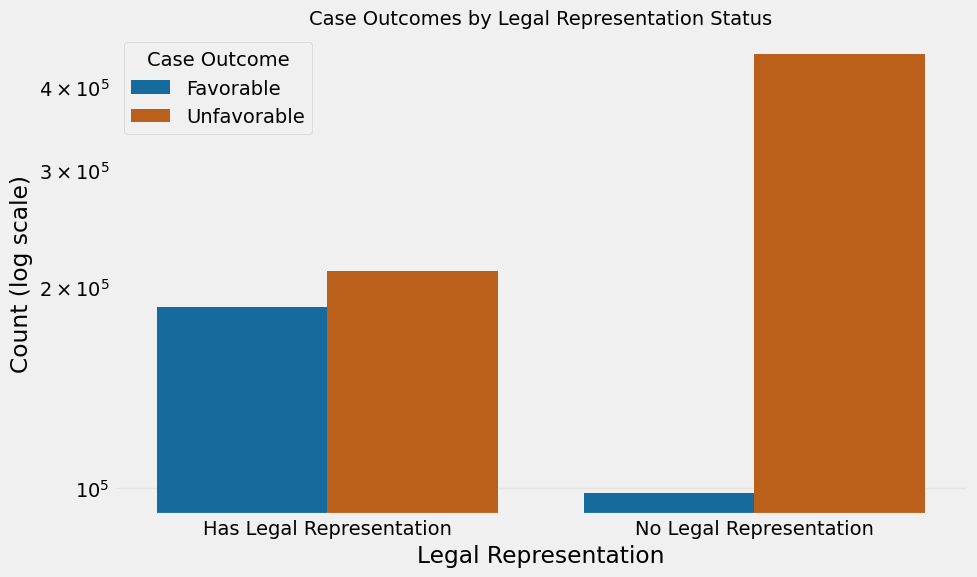

In [199]:
# Counts (log-scaled)

order_rep = ["Has Legal Representation", "No Legal Representation"]
order_outcome = ["Favorable", "Unfavorable"]
palette = {"Favorable": "#0071B2", "Unfavorable": "#D55C00"}

plt.figure(figsize=(10, 6))
sns.countplot(
    data=analysis_filtered,
    x="HAS_LEGAL_REP",
    hue="BINARY_OUTCOME",
    order=order_rep,
    hue_order=order_outcome,
    palette=palette,
)
plt.yscale("log")
plt.title("Case Outcomes by Legal Representation Status", fontsize=14)
plt.xlabel("Legal Representation")
plt.ylabel("Count (log scale)")
plt.xticks(rotation=0)
plt.legend(title="Case Outcome")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()

plt.savefig(
    "../figures/case_outcomes_by_representation.png", dpi=300, bbox_inches="tight"
)

plt.show()

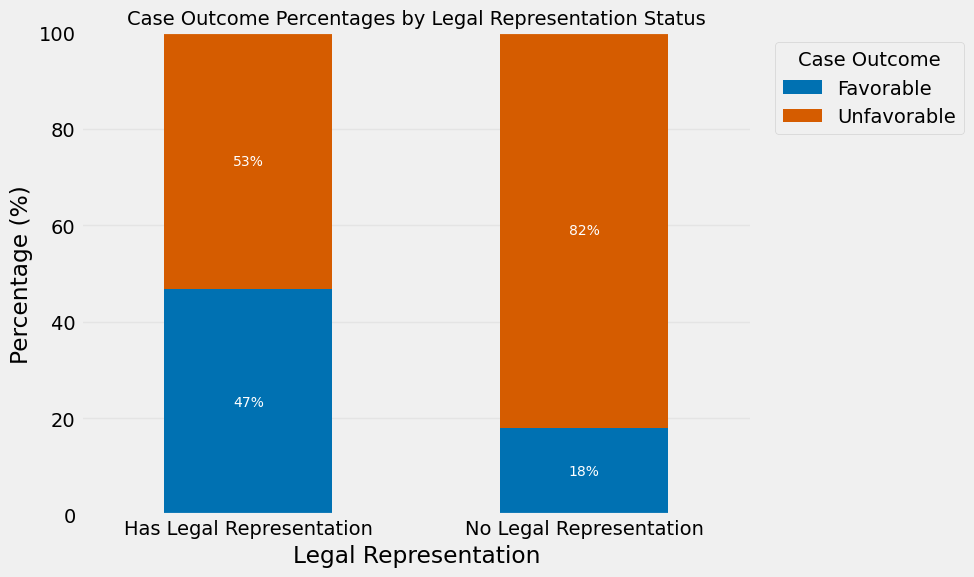

In [200]:
# Percentages (stacked)

order_rep = ["Has Legal Representation", "No Legal Representation"]
order_outcome = ["Favorable", "Unfavorable"]
palette = ["#0071B2", "#D55C00"]  

percentage_data = (
    pd.crosstab(
        analysis_filtered["HAS_LEGAL_REP"],
        analysis_filtered["BINARY_OUTCOME"],
        normalize="index",
    )
    .reindex(index=order_rep, columns=order_outcome)
    .mul(100)
    .round(1)
)

ax = percentage_data.plot(
    kind="bar", stacked=True, figsize=(10, 6), color=palette, edgecolor="none"
)
plt.title("Case Outcome Percentages by Legal Representation Status", fontsize=14)
plt.xlabel("Legal Representation")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
plt.legend(title="Case Outcome", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(axis="y", alpha=0.3)
plt.ylim(0, 100)

# annotate percentages
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height > 3:  
        x = p.get_x() + width / 2
        y = p.get_y() + height / 2
        ax.text(
            x, y, f"{height:.0f}%", ha="center", va="center", fontsize=10, color="white"
        )

plt.tight_layout()

plt.savefig(
    "../figures/case_outcomes_percentages_by_representation.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

In [ ]:
# Relationship between case outcomes and policy eras

era_order = [
    "Trump Era I (Apr 2018 – Jan 2021)",
    "Biden Era (Jan 2021 – Apr 2025)",
    "Trump Era II (Apr 2025 – Present)",
]

# Counts by policy era
outcome_by_era = pd.crosstab(
    analysis_filtered["BINARY_OUTCOME"],
    analysis_filtered["POLICY_ERA"],
).reindex(index=outcome_order, columns=era_order)

display(outcome_by_era)

# Percentages within each policy era column
outcome_by_era_pct = (
    pd.crosstab(
        analysis_filtered["BINARY_OUTCOME"],
        analysis_filtered["POLICY_ERA"],
        normalize="columns",
    )
    .reindex(index=outcome_order, columns=era_order)
    .multiply(100)
    .round(1)
)

display(
    outcome_by_era_pct.style.format("{:.1f}%").set_caption(
        "Outcome % within Policy Era"
    )
)

POLICY_ERA,Trump Era I (Apr 2018 – Jan 2021),Biden Era (Jan 2021 – Apr 2025),Trump Era II (Apr 2025 – Present)
BINARY_OUTCOME,,,
Favorable,78177,201575,4881
Unfavorable,300921,341498,16656


POLICY_ERA,Trump Era I (Apr 2018 – Jan 2021),Biden Era (Jan 2021 – Apr 2025),Trump Era II (Apr 2025 – Present)
BINARY_OUTCOME,,,
Favorable,20.6%,37.1%,22.7%
Unfavorable,79.4%,62.9%,77.3%


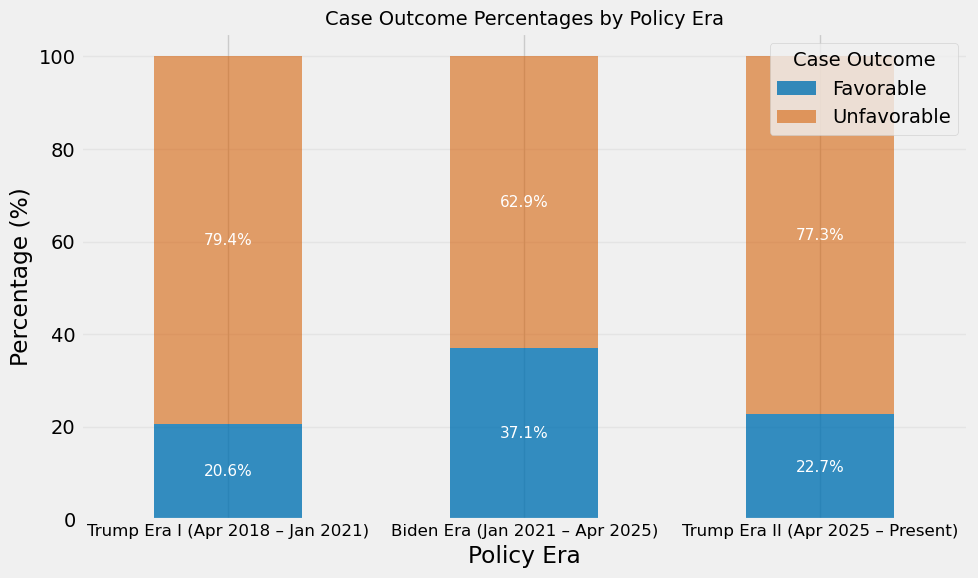

In [201]:
# Visualize the relationship between policy era and outcomes (percentage bar plot)

percentage_colors = {"Favorable": "#0071B2C9", "Unfavorable": "#D55C0091"}

ax = outcome_by_era_pct.T.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    color=[percentage_colors[col] for col in outcome_by_era_pct.index],
)

plt.title("Case Outcome Percentages by Policy Era", fontsize=14)
plt.xlabel("Policy Era")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0, fontsize=12)
plt.legend(title="Case Outcome")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()

# annotate percentages
for c in ax.containers:
    ax.bar_label(c, fmt="%.1f%%", label_type="center", fontsize=11, color="white")

plt.savefig(
    "../figures/case_outcomes_percentages_by_policy_era.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

In [197]:
# Relationship between legal representation and policy era
rep_by_era = pd.crosstab(
    analysis_filtered["POLICY_ERA"],
    analysis_filtered["HAS_LEGAL_REP"],
).reindex(index=era_order, columns=rep_order)

display(rep_by_era)

# Row-percentages
rep_by_era_pct = (
    pd.crosstab(
        analysis_filtered["POLICY_ERA"],
        analysis_filtered["HAS_LEGAL_REP"],
        normalize="index",
    )
    .reindex(index=era_order, columns=rep_order)
    .multiply(100)
    .round(1)
)

display(
    rep_by_era_pct.style.format("{:.1f}%").set_caption(
        "Representation % within Policy Era"
    )
)

HAS_LEGAL_REP,Has Legal Representation,No Legal Representation
POLICY_ERA,,
Trump Era I (Apr 2018 – Jan 2021),151979,227119
Biden Era (Jan 2021 – Apr 2025),234974,308099
Trump Era II (Apr 2025 – Present),11003,10534


HAS_LEGAL_REP,Has Legal Representation,No Legal Representation
POLICY_ERA,,
Trump Era I (Apr 2018 – Jan 2021),40.1%,59.9%
Biden Era (Jan 2021 – Apr 2025),43.3%,56.7%
Trump Era II (Apr 2025 – Present),51.1%,48.9%


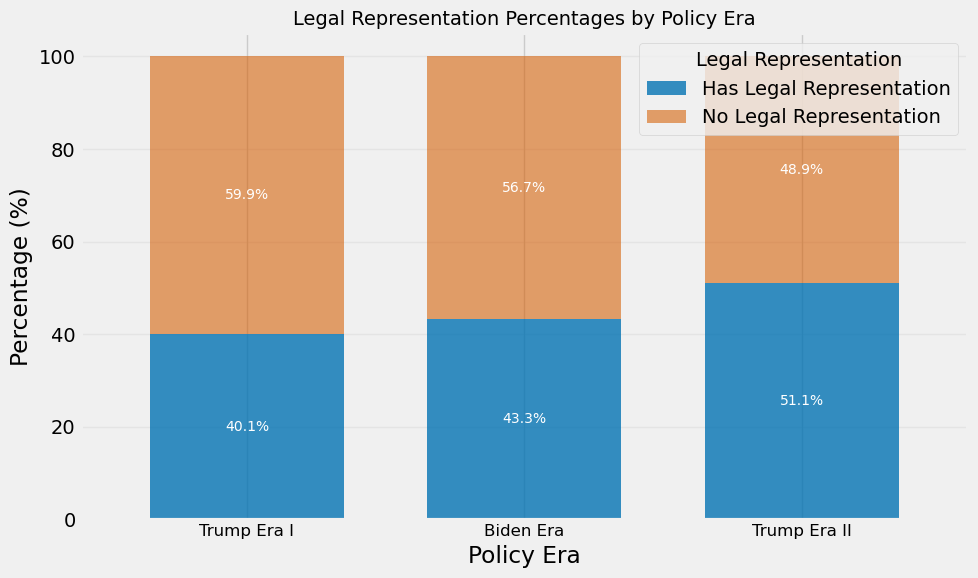

In [202]:
# Visualize the relationship between policy era and legal representation (percentage bar plot)
fig, ax = plt.subplots(figsize=(10, 6))
percentage_colors = ["#0071B2C9", "#D55C0091"]  

rep_by_era_pct.plot(kind="bar", stacked=True, color=percentage_colors, ax=ax, width=0.7)

ax.set_title("Legal Representation Percentages by Policy Era", fontsize=14)
ax.set_xlabel("Policy Era")
ax.set_ylabel("Percentage (%)")

labels = ["Trump Era I", "Biden Era", "Trump Era II"]
ax.set_xticklabels(labels, fontsize=12, rotation=0)

ax.legend(title="Legal Representation")

ax.grid(axis="y", alpha=0.3)

for container in ax.containers:
    ax.bar_label(
        container, fmt="%.1f%%", label_type="center", fontsize=10, color="white"
    )

plt.tight_layout()

plt.savefig(
    "../figures/legal_representation_percentages_by_policy_era.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

## 6. Time Series Analysis

Time series analysis examines how data points change over sequential time periods. In this immigration policy study, this method enables the evaluation of trends across different administrative periods to assess how policy changes have impacted juvenile cases.

By tracking representation rates and outcomes chronologically, patterns can be identified that may correlate with specific policy initiatives or administrative priorities. Statistical significance testing between periods determines whether observed differences represent meaningful policy effects rather than random variation.

The following analysis examines how legal representation rates have changed over time, particularly across different policy eras.

## 6. Time Series Analysis

Time series analysis examines how data points change over sequential time periods.  
In this immigration policy study, this method enables the evaluation of trends across different administrative periods to assess how policy changes have impacted juvenile cases.

By tracking representation rates and outcomes chronologically, patterns can be identified that may correlate with specific policy initiatives or administrative priorities.  
Statistical significance testing between periods determines whether observed differences represent meaningful policy effects rather than random variation.

The following analysis examines how legal representation rates have changed over time, particularly across different policy eras.

In [ ]:
# Calculate all required metrics in a single groupby aggregation
era_summary = analysis_filtered.groupby("POLICY_ERA").agg(
    total_cases=("HAS_LEGAL_REP", "count"),
    represented_cases=(
        "HAS_LEGAL_REP",
        lambda x: (x == "Has Legal Representation").sum(),
    ),
    favorable_cases=("BINARY_OUTCOME", lambda x: (x == "Favorable").sum()),
)

era_summary["representation_rate"] = (
    era_summary["represented_cases"] / era_summary["total_cases"]
)
era_summary["favorable_rate"] = (
    era_summary["favorable_cases"] / era_summary["total_cases"]
)

print("Summary by Policy Era:")
display(era_summary)

Summary by Policy Era:


,total_cases,represented_cases,favorable_cases,representation_rate,favorable_rate
POLICY_ERA,,,,,
Biden Era (Jan 2021 – Apr 2025),543073,234974,201575,0.432675,0.371175
Trump Era I (Apr 2018 – Jan 2021),379098,151979,78177,0.400896,0.206218
Trump Era II (Apr 2025 – Present),21537,11003,4881,0.510888,0.226633


In [ ]:
# Create a time series with quarterly data
# Only include records with valid dates
date_valid = ~analysis_filtered["hearing_date_combined"].isna()
time_series_df = analysis_filtered[date_valid].copy()

# Create year-quarter field
time_series_df["YEAR_QUARTER"] = time_series_df["hearing_date_combined"].dt.to_period(
    "Q"
)

# ADDITION: Focus on data from the last 10 years (2015 to present)
current_date = pd.Timestamp.now()
start_date = pd.Timestamp("2016-01-01")  # Just before Trump's first term
recent_data = time_series_df[time_series_df["hearing_date_combined"] >= start_date]
recent_data = recent_data[recent_data["hearing_date_combined"] <= current_date]

print(f"Total number of records: {len(time_series_df):,}")
print(f"Records from 2015 to present: {len(recent_data):,}")

# Calculate quarterly representation rates and favorable outcome rates using recent data
quarterly_rep = recent_data.groupby("YEAR_QUARTER").agg(
    total_cases=("HAS_LEGAL_REP", "count"),
    represented_cases=(
        "HAS_LEGAL_REP",
        lambda x: (x == "Has Legal Representation").sum(),
    ),
    favorable_cases=("BINARY_OUTCOME", lambda x: (x == "Favorable").sum()),
)
quarterly_rep["representation_rate"] = (
    quarterly_rep["represented_cases"] / quarterly_rep["total_cases"]
)
quarterly_rep["favorable_rate"] = (
    quarterly_rep["favorable_cases"] / quarterly_rep["total_cases"]
)

# Display quarterly data
print("Quarterly Legal Representation and Favorable Outcome Rates (Last 10 years):")
display(quarterly_rep.head(40))

Total number of records: 943,708
Records from 2015 to present: 941,879
Quarterly Legal Representation and Favorable Outcome Rates (Last 10 years):


,total_cases,represented_cases,favorable_cases,representation_rate,favorable_rate
YEAR_QUARTER,,,,,
2018Q2,20903,8233,3829,0.393867,0.183179
2018Q3,27467,11165,6245,0.406488,0.227364
2018Q4,32394,11847,5193,0.365716,0.160307
2019Q1,33414,12024,5213,0.359849,0.156012
2019Q2,46900,17118,7686,0.364989,0.163881
2019Q3,57046,21921,11843,0.384269,0.207604
2019Q4,59929,22631,12220,0.377630,0.203908
2020Q1,59047,22302,10340,0.377699,0.175115
2020Q2,12823,6935,4002,0.540825,0.312095


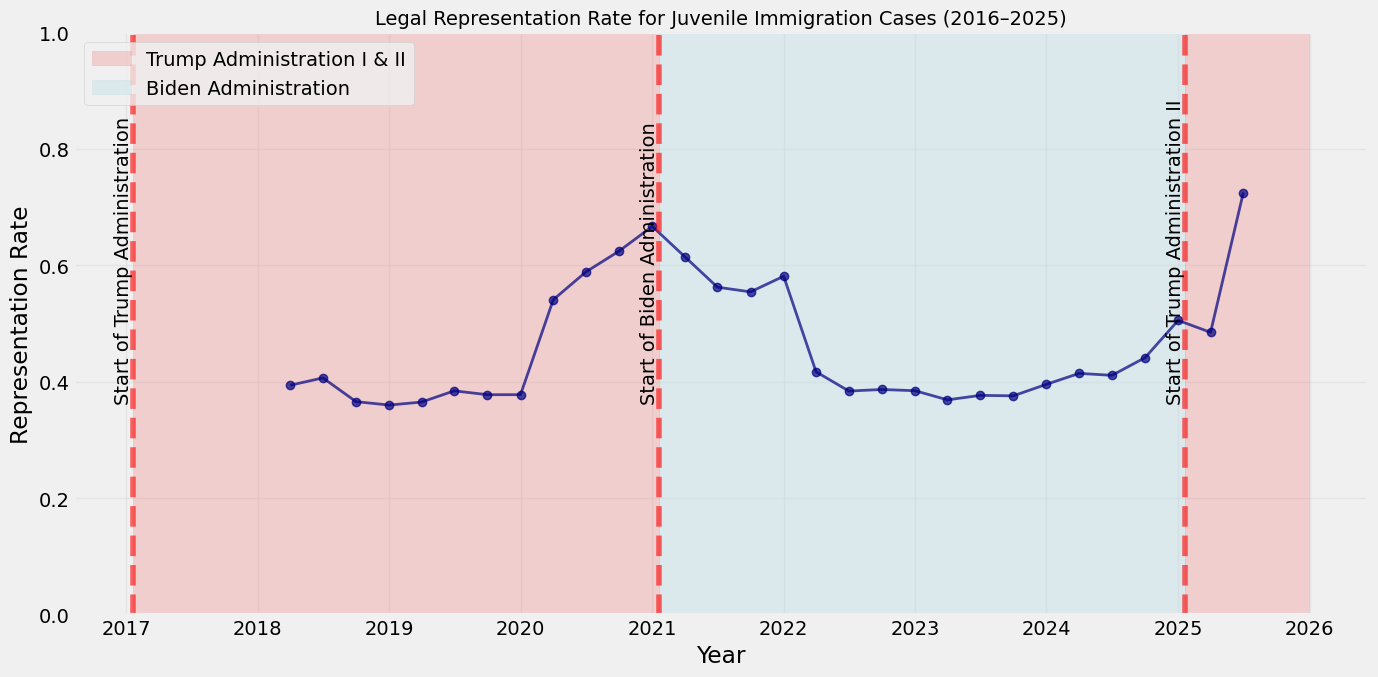

In [ ]:
# Add YEAR_QUARTER_START as timestamp index
quarterly_rep["YEAR_QUARTER_START"] = quarterly_rep.index.to_timestamp()

# Define timeframe
start_date = pd.Timestamp("2016-01-01")
end_date = pd.Timestamp("2025-12-31")
current_date = pd.Timestamp.today()

# Filter data within the timeframe
filtered_data = quarterly_rep[
    (quarterly_rep["YEAR_QUARTER_START"] >= start_date)
    & (quarterly_rep["YEAR_QUARTER_START"] <= current_date)
]

# Plot setup
fig, ax = plt.subplots(figsize=(14, 7))

# Plot representation rate
ax.plot(
    filtered_data["YEAR_QUARTER_START"],
    filtered_data["representation_rate"],
    marker="o",
    linestyle="-",
    color="navy",
    linewidth=2,
    alpha=0.7,
)

# Background shading for administrations
ax.axvspan(
    pd.Timestamp("2017-01-20"),
    pd.Timestamp("2021-01-20"),
    color="lightcoral",
    alpha=0.3,
)
ax.axvspan(
    pd.Timestamp("2021-01-20"), pd.Timestamp("2025-01-20"), color="lightblue", alpha=0.3
)
ax.axvspan(
    pd.Timestamp("2025-01-20"),
    pd.Timestamp("2025-12-31"),
    color="lightcoral",
    alpha=0.3,
)

# Vertical lines and labels for administration changes
admin_changes = [
    (pd.Timestamp("2017-01-20"), "Start of Trump Administration"),
    (pd.Timestamp("2021-01-20"), "Start of Biden Administration"),
    (pd.Timestamp("2025-01-20"), "Start of Trump Administration II"),
]

for date, label in admin_changes:
    ax.axvline(x=date, color="red", linestyle="--", alpha=0.6)
    ax.text(
        date,
        ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.05,
        label,
        rotation=90,
        va="bottom",
        ha="right",
    )

# Legend patches for administration periods
trump_patch = mpatches.Patch(
    color="lightcoral", alpha=0.3, label="Trump Administration I & II"
)
biden_patch = mpatches.Patch(color="lightblue", alpha=0.3, label="Biden Administration")

handles, labels = ax.get_legend_handles_labels()
handles.extend([trump_patch, biden_patch])
ax.legend(handles=handles, loc="upper left")

# Titles and labels
ax.set_title(
    "Legal Representation Rate for Juvenile Immigration Cases (2016–2025)", fontsize=14
)
ax.set_xlabel("Year")
ax.set_ylabel("Representation Rate")
ax.set_ylim(0, 1)
ax.grid(alpha=0.3)

# Format x-axis ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_major_locator(mdates.YearLocator())

plt.tight_layout()
plt.show()

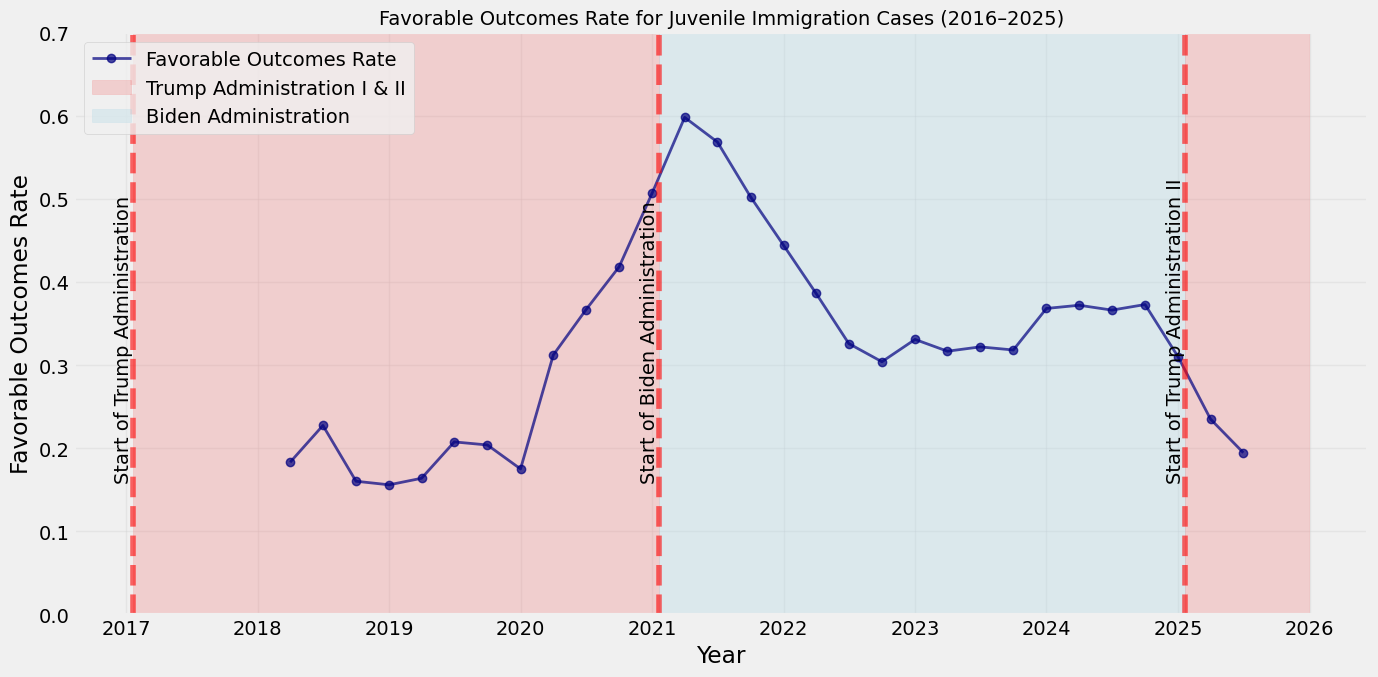

In [ ]:
# Plot Favorable Outcomes rates over time with focused timeframe
fig, ax = plt.subplots(figsize=(14, 7))

# Plot main line
ax.plot(
    filtered_data["YEAR_QUARTER_START"],
    filtered_data["favorable_rate"],
    marker="o",
    linestyle="-",
    color="navy",
    linewidth=2,
    alpha=0.7,
    label="Favorable Outcomes Rate",
)

# Administration background shading
ax.axvspan(
    pd.Timestamp("2017-01-20"),
    pd.Timestamp("2021-01-20"),
    color="lightcoral",
    alpha=0.3,
)
ax.axvspan(
    pd.Timestamp("2021-01-20"), pd.Timestamp("2025-01-20"), color="lightblue", alpha=0.3
)
ax.axvspan(
    pd.Timestamp("2025-01-20"),
    pd.Timestamp("2025-12-31"),
    color="lightcoral",
    alpha=0.3,
)

# Vertical lines and annotations for administration changes
admin_changes = [
    (pd.Timestamp("2017-01-20"), "Start of Trump Administration"),
    (pd.Timestamp("2021-01-20"), "Start of Biden Administration"),
    (pd.Timestamp("2025-01-20"), "Start of Trump Administration II"),
]

ymin, ymax = ax.get_ylim()

for date, label in admin_changes:
    ax.axvline(x=date, color="red", linestyle="--", alpha=0.6)
    ax.text(
        date,
        ymin + (ymax - ymin) * 0.05,
        label,
        rotation=90,
        va="bottom",
        ha="right",
    )

# Legend patches
trump_patch = mpatches.Patch(
    color="lightcoral", alpha=0.3, label="Trump Administration I & II"
)
biden_patch = mpatches.Patch(color="lightblue", alpha=0.3, label="Biden Administration")

handles, labels = ax.get_legend_handles_labels()
handles.extend([trump_patch, biden_patch])
ax.legend(handles=handles, loc="upper left")

# Titles and axes
ax.set_title(
    "Favorable Outcomes Rate for Juvenile Immigration Cases (2016–2025)", fontsize=14
)
ax.set_xlabel("Year")
ax.set_ylabel("Favorable Outcomes Rate")
ax.set_ylim(0, 0.7)
ax.grid(alpha=0.3)

# Format x-axis ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_major_locator(mdates.YearLocator())

plt.tight_layout()
plt.show()

## 7. Chi-Square Analysis

Chi-square tests assess associations between categorical variables by comparing observed and expected frequencies under the null hypothesis, with p-values below 0.05 indicating statistical significance. 

When significant associations are found, **Cramer's V** is calculated to determine the strength of the association. Its interpretation depends on the degrees of freedom (df) of the table:
- **For df = 1:**  
  - 0 – 0.10: Negligible  
  - 0.10 – 0.30: Small  
  - 0.30 – 0.50: Medium  
  - 0.50 and above: Large
- **For df = 2:**  
  - 0 – 0.07: Negligible  
  - 0.07 – 0.21: Small  
  - 0.21 – 0.35: Medium  
  - 0.35 and above: Large  
  
Additionally, odds ratios (OR) provide a complementary measure by quantifying the relative likelihood of favorable outcomes for juveniles with legal representation compared to those without, where OR > 1 indicates increased odds associated with representation.

These statistical approaches are applied to examine how legal representation relates to case outcomes and varies across policy eras in juvenile immigration proceedings.

In [ ]:
# Exclude "other" category from POLICY_ERA and "Unknown" from HAS_LEGAL_REP if needed
era_rep_table = pd.crosstab(
    analysis_filtered.loc[
        (analysis_filtered["HAS_LEGAL_REP"] != "other")
        & (analysis_filtered["HAS_LEGAL_REP"] != "Unknown")
    ]["POLICY_ERA"],
    analysis_filtered.loc[
        (analysis_filtered["HAS_LEGAL_REP"] != "other")
        & (analysis_filtered["HAS_LEGAL_REP"] != "Unknown")
    ]["HAS_LEGAL_REP"],
)
print("Contingency Table: Legal Representation by Policy Era (excluding 'other')")
display(era_rep_table)

Contingency Table: Legal Representation by Policy Era (excluding 'other')


HAS_LEGAL_REP,Has Legal Representation,No Legal Representation
POLICY_ERA,,
Biden Era (Jan 2021 – Apr 2025),234974,308099
Trump Era I (Apr 2018 – Jan 2021),151979,227119
Trump Era II (Apr 2025 – Present),11003,10534


In [ ]:
# Exclude "Other" from BINARY_OUTCOME
era_outcome_table = pd.crosstab(
    analysis_filtered[analysis_filtered["BINARY_OUTCOME"] != "Other"]["POLICY_ERA"],
    analysis_filtered[analysis_filtered["BINARY_OUTCOME"] != "Other"]["BINARY_OUTCOME"],
)
print("Contingency Table: Cases Outcome by Policy Era (excluding 'Other')")
display(era_outcome_table)

Contingency Table: Cases Outcome by Policy Era (excluding 'Other')


BINARY_OUTCOME,Favorable,Unfavorable
POLICY_ERA,,
Biden Era (Jan 2021 – Apr 2025),201575,341498
Trump Era I (Apr 2018 – Jan 2021),78177,300921
Trump Era II (Apr 2025 – Present),4881,16656


In [ ]:
# Perform chi-square test for legal representation by policy era
chi2_era_rep, p_era_rep, dof_era_rep, expected_era_rep = stats.chi2_contingency(
    era_rep_table
)

# Calculate Cramer's V for effect size
n = era_rep_table.values.sum()
cramer_v = np.sqrt(chi2_era_rep / (n * (min(era_rep_table.shape) - 1)))

print("Chi-Square Test Results: Legal Representation by Policy Era")
print(f"Chi-square statistic: {chi2_era_rep:.2f}")
print(f"p-value: {p_era_rep}")
print(f"Degrees of freedom: {dof_era_rep}")
print("\nInterpretation:")
if p_era_rep < 0.05:
    print(
        "The relationship between policy era and legal representation is statistically significant (p < 0.05)."
    )
    print(
        "The null hypothesis that there is no association between these variables can be rejected."
    )
else:
    print(
        "No statistically significant relationship was found between policy era and legal representation."
    )
print(f"\nCramer's V (effect size): {cramer_v:.3f}")
if dof_era_rep == 1:
    if cramer_v < 0.1:
        print("This indicates a negligible effect size.")
    elif cramer_v < 0.3:
        print("This indicates a small effect size.")
    elif cramer_v < 0.5:
        print("This indicates a medium effect size.")
    else:
        print("This indicates a large effect size.")
elif dof_era_rep == 2:
    if cramer_v < 0.07:
        print("This indicates a negligible effect size.")
    elif cramer_v < 0.21:
        print("This indicates a small effect size.")
    elif cramer_v < 0.35:
        print("This indicates a medium effect size.")
    else:
        print("This indicates a large effect size.")

Chi-Square Test Results: Legal Representation by Policy Era
Chi-square statistic: 1643.51
p-value: 0.0
Degrees of freedom: 2

Interpretation:
The relationship between policy era and legal representation is statistically significant (p < 0.05).
The null hypothesis that there is no association between these variables can be rejected.

Cramer's V (effect size): 0.042
This indicates a negligible effect size.


Next, the relationship between legal representation and case outcomes is examined to determine how representation affects the likelihood of favorable outcomes for juvenile cases.

In [ ]:
# Perform chi-square test for cases outcome by policy era
chi2_era_outcome, p_era_outcome, dof_era_outcome, expected_era_outcome = (
    stats.chi2_contingency(era_outcome_table)
)

# Calculate Cramer's V for effect size
n = era_outcome_table.values.sum()
cramer_v = np.sqrt(chi2_era_outcome / (n * (min(era_outcome_table.shape) - 1)))

print("Chi-Square Test Results: cases outcome by Policy Era")
print(f"Chi-square statistic: {chi2_era_outcome:.2f}")
print(f"p-value: {p_era_outcome}")
print(f"Degrees of freedom: {dof_era_outcome}")
print("\nInterpretation:")
if p_era_outcome < 0.05:
    print(
        "The relationship between policy era and cases outcome is statistically significant (p < 0.05)."
    )
    print(
        "The null hypothesis that there is no association between these variables can be rejected."
    )
else:
    print(
        "No statistically significant relationship was found between policy era and cases outcome."
    )
print(f"\nCramer's V (effect size): {cramer_v:.3f}")
if dof_era_outcome == 1:
    if cramer_v < 0.1:
        print("This indicates a negligible effect size.")
    elif cramer_v < 0.3:
        print("This indicates a small effect size.")
    elif cramer_v < 0.5:
        print("This indicates a medium effect size.")
    else:
        print("This indicates a large effect size.")
elif dof_era_outcome == 2:
    if cramer_v < 0.07:
        print("This indicates a negligible effect size.")
    elif cramer_v < 0.21:
        print("This indicates a small effect size.")
    elif cramer_v < 0.35:
        print("This indicates a medium effect size.")
    else:
        print("This indicates a large effect size.")

Chi-Square Test Results: cases outcome by Policy Era
Chi-square statistic: 29427.96
p-value: 0.0
Degrees of freedom: 2

Interpretation:
The relationship between policy era and cases outcome is statistically significant (p < 0.05).
The null hypothesis that there is no association between these variables can be rejected.

Cramer's V (effect size): 0.177
This indicates a small effect size.


In [ ]:
# Create a contingency table for case outcomes by legal representation
outcome_rep_table = pd.crosstab(
    analysis_filtered["BINARY_OUTCOME"], analysis_filtered["HAS_LEGAL_REP"]
)
print("Contingency Table: Case Outcomes by Legal Representation")
display(outcome_rep_table)

Contingency Table: Case Outcomes by Legal Representation


HAS_LEGAL_REP,Has Legal Representation,No Legal Representation
BINARY_OUTCOME,,
Favorable,186398,98235
Unfavorable,211558,447517


In [ ]:
# Perform chi-square test for case outcomes by legal representation
chi2_outcome_rep, p_outcome_rep, dof_outcome_rep, expected_outcome_rep = (
    stats.chi2_contingency(outcome_rep_table)
)

# Calculate Cramer's V for effect size
n = outcome_rep_table.values.sum()
cramer_v = np.sqrt(chi2_outcome_rep / (n * (min(outcome_rep_table.shape) - 1)))

print("Chi-Square Test Results: Case Outcomes by Legal Representation")
print(f"Chi-square statistic: {chi2_outcome_rep:.2f}")
print(f"p-value: {p_outcome_rep}")
print(f"Degrees of freedom: {dof_outcome_rep}")
print("\nInterpretation:")
if p_outcome_rep < 0.05:
    print(
        "The relationship between legal representation and case outcomes is statistically significant (p < 0.05)."
    )
    print(
        "The null hypothesis that there is no association between these variables can be rejected."
    )
else:
    print(
        "No statistically significant relationship was found between legal representation and case outcomes."
    )
print(f"\nCramer's V (effect size): {cramer_v:.3f}")

if dof_outcome_rep == 1:
    if cramer_v < 0.1:
        print("This indicates a negligible effect size.")
    elif cramer_v < 0.3:
        print("This indicates a small effect size.")
    elif cramer_v < 0.5:
        print("This indicates a medium effect size.")
    else:
        print("This indicates a large effect size.")
elif dof_outcome_rep == 2:
    if cramer_v < 0.07:
        print("This indicates a negligible effect size.")
    elif cramer_v < 0.21:
        print("This indicates a small effect size.")
    elif cramer_v < 0.35:
        print("This indicates a medium effect size.")
    else:
        print("This indicates a large effect size.")

Chi-Square Test Results: Case Outcomes by Legal Representation
Chi-square statistic: 90865.53
p-value: 0.0
Degrees of freedom: 1

Interpretation:
The relationship between legal representation and case outcomes is statistically significant (p < 0.05).
The null hypothesis that there is no association between these variables can be rejected.

Cramer's V (effect size): 0.310
This indicates a medium effect size.


In [ ]:
# Calculate odds ratio for favorable outcomes by representation
a = outcome_rep_table.loc["Favorable", "Has Legal Representation"]
b = outcome_rep_table.loc["Unfavorable", "Has Legal Representation"]
c = outcome_rep_table.loc["Favorable", "No Legal Representation"]
d = outcome_rep_table.loc["Unfavorable", "No Legal Representation"]

odds_with_rep = a / b
odds_without_rep = c / d
odds_ratio = odds_with_rep / odds_without_rep

print("\nOdds Ratio Calculation:")
print(f"Odds of favorable outcome with representation: {odds_with_rep:.3f}")
print(f"Odds of favorable outcome without representation: {odds_without_rep:.3f}")
print(f"Odds ratio: {odds_ratio:.3f}")
print(
    f"\nInterpretation: Juveniles with legal representation are {odds_ratio:.2f} times more likely to receive a favorable outcome compared to those without representation."
)


Odds Ratio Calculation:
Odds of favorable outcome with representation: 0.890
Odds of favorable outcome without representation: 0.199
Odds ratio: 4.478

Interpretation: Juveniles with legal representation are 4.48 times more likely to receive a favorable outcome compared to those without representation.


## 8. Logistic Regression Analysis

Logistic regression models the probability of binary outcomes based on multiple predictor variables. A comprehensive model examines the combined effects of legal representation, policy era, age categories, and gender on favorable case outcomes for juvenile immigrants, using dummy variables with reference categories as comparison baselines.

This approach allows for the estimation of each factor's independent contribution while controlling for other variables, quantifying effects through odds ratios with 95% confidence intervals.

Model performance is evaluated using accuracy and AUC-ROC metrics, providing a robust framework for determining the independent effect of legal representation on juvenile immigration case outcomes across different policy eras.

In [ ]:
print("Preparing data for logistic regression...")

# Create a dataset for logistic regression
regression_data = analysis_filtered.copy()

# Create a binary target variable (1 = favorable outcome, 0 = unfavorable)
regression_data["FAVORABLE"] = regression_data["BINARY_OUTCOME"].apply(
    lambda x: 1 if x == "Favorable" else 0
)

# Create binary legal representation variable (1 = has representation, 0 = no representation)
regression_data["HAS_LEGAL_REP_BINARY"] = regression_data["HAS_LEGAL_REP"].apply(
    lambda x: 1 if x == "Has Legal Representation" else 0
)

# Create policy era dummy variables
regression_data["POLICY_ERA_Biden"] = (
    regression_data["POLICY_ERA"] == "Biden Era (Jan 2021 – Apr 2025)"
).astype(int)
regression_data["POLICY_ERA_Trump_I"] = (
    regression_data["POLICY_ERA"] == "Trump Era I (Apr 2018 – Jan 2021)"
).astype(int)
regression_data["POLICY_ERA_Trump_II"] = (
    regression_data["POLICY_ERA"] == "Trump Era II (Apr 2025 – Present)"
).astype(int)

# Create gender variable (1 = female, 0 = male)
regression_data["GENDER_BINARY"] = regression_data["Sex"].apply(
    lambda x: 1 if x == "F" else 0 if x == "M" else np.nan
)


# Create age category variables
def categorize_age(age):
    if pd.isna(age):
        return np.nan
    elif age < 12:
        return "Under_12"
    elif age < 16:
        return "12_to_15"
    elif age < 18:
        return "16_to_17"
    else:
        return "18_plus"


regression_data["AGE_CATEGORY"] = regression_data["AGE_AT_FILING"].apply(categorize_age)

# Create dummy variables for age categories
regression_data["AGE_CATEGORY_Under_12"] = (
    regression_data["AGE_CATEGORY"] == "Under_12"
).astype(int)
regression_data["AGE_CATEGORY_12_to_15"] = (
    regression_data["AGE_CATEGORY"] == "12_to_15"
).astype(int)
regression_data["AGE_CATEGORY_16_to_17"] = (
    regression_data["AGE_CATEGORY"] == "16_to_17"
).astype(int)

# List of features for the model
features = [
    "HAS_LEGAL_REP_BINARY",
    "POLICY_ERA_Biden",
    "POLICY_ERA_Trump_I",
    "POLICY_ERA_Trump_II",
    "GENDER_BINARY",
    "AGE_CATEGORY_12_to_15",
    "AGE_CATEGORY_16_to_17",
    "AGE_CATEGORY_Under_12",
]

print(f"Features to be used in the model: {features}")

Preparing data for logistic regression...
Features to be used in the model: ['HAS_LEGAL_REP_BINARY', 'POLICY_ERA_Biden', 'POLICY_ERA_Trump_I', 'POLICY_ERA_Trump_II', 'GENDER_BINARY', 'AGE_CATEGORY_12_to_15', 'AGE_CATEGORY_16_to_17', 'AGE_CATEGORY_Under_12']


In [ ]:
print("Running logistic regression...")

# Drop rows with missing values in the features or target
regression_df = regression_data.dropna(subset=["FAVORABLE"] + features)
print(f"Sample size: {len(regression_df):,} cases with complete data")

# Prepare X and y - statsmodels requires adding a constant
X = sm.add_constant(regression_df[features])
y = regression_df["FAVORABLE"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Fit the model
model = sm.Logit(y_train, X_train)
results = model.fit(disp=0)  # disp=0 suppresses convergence messages

# Get predictions for evaluation
y_pred = results.predict(X_test) > 0.5
y_prob = results.predict(X_test)

# Get summary table with proper standard errors
summary_df = results.summary2().tables[1]

# Create odds ratios and confidence intervals
odds_ratios = np.exp(summary_df["Coef."])
ci_lower = np.exp(summary_df["Coef."] - 1.96 * summary_df["Std.Err."])
ci_upper = np.exp(summary_df["Coef."] + 1.96 * summary_df["Std.Err."])

# Create a DataFrame with the results (excluding the constant)
results_df = pd.DataFrame(
    {
        "Feature": ["Intercept"] + features,
        "Coefficient": summary_df["Coef."],
        "Std Error": summary_df["Std.Err."],
        "z-score": summary_df["z"],
        "p-value": summary_df["P>|z|"],
        "Odds Ratio": odds_ratios,
        "95% CI Lower": ci_lower,
        "95% CI Upper": ci_upper,
    }
)

# Add significance indicators
results_df["Significance"] = results_df["p-value"].apply(
    lambda p: "***"
    if p < 0.001
    else ("**" if p < 0.01 else ("*" if p < 0.05 else "ns"))
)

# Calculate model evaluation metrics

accuracy = accuracy_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob)

# Display results
print("\nLogistic Regression Results:")
display(
    results_df[
        [
            "Feature",
            "Odds Ratio",
            "95% CI Lower",
            "95% CI Upper",
            "p-value",
            "Significance",
        ]
    ].round(3)
)

print("\nModel Evaluation:")
print(f"Accuracy: {accuracy:.3f}")
print(f"AUC-ROC: {auc_roc:.3f}")

Running logistic regression...
Sample size: 846,032 cases with complete data

Logistic Regression Results:


,Feature,Odds Ratio,95% CI Lower,95% CI Upper,p-value,Significance
const,Intercept,0.163,0.160,0.166,0.000,***
HAS_LEGAL_REP_BINARY,HAS_LEGAL_REP_BINARY,5.455,5.386,5.524,0.000,***
POLICY_ERA_Biden,POLICY_ERA_Biden,1.435,1.409,1.462,0.000,***
POLICY_ERA_Trump_I,POLICY_ERA_Trump_I,0.547,0.536,0.559,0.000,***
POLICY_ERA_Trump_II,POLICY_ERA_Trump_II,0.595,0.566,0.624,0.000,***
GENDER_BINARY,GENDER_BINARY,1.239,1.223,1.255,0.000,***
AGE_CATEGORY_12_to_15,AGE_CATEGORY_12_to_15,1.001,0.976,1.026,0.947,ns
AGE_CATEGORY_16_to_17,AGE_CATEGORY_16_to_17,0.908,0.885,0.932,0.000,***
AGE_CATEGORY_Under_12,AGE_CATEGORY_Under_12,0.730,0.716,0.744,0.000,***



Model Evaluation:
Accuracy: 0.752
AUC-ROC: 0.749


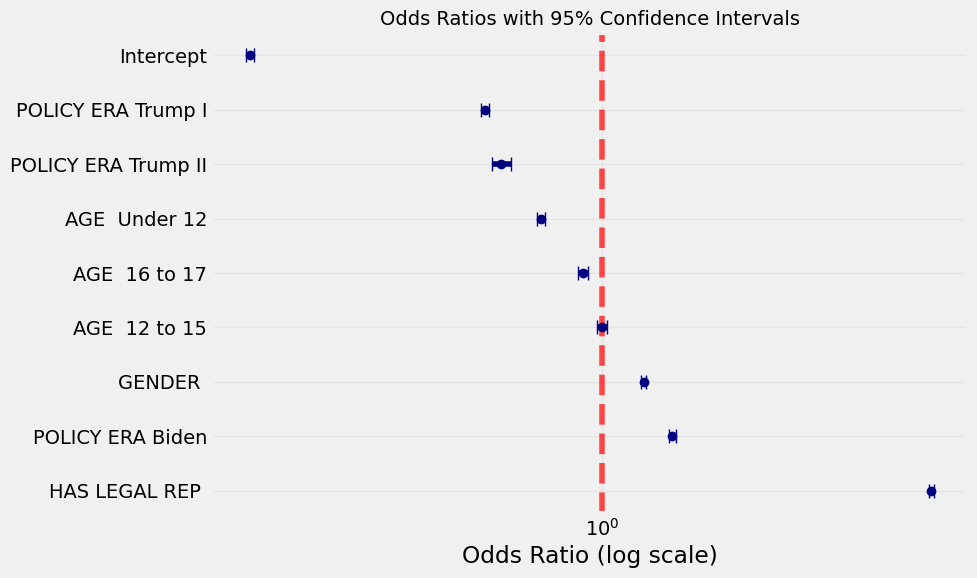

In [ ]:
# Visualize the odds ratios with confidence intervals
plt.figure(figsize=(10, 6))
results_plot = results_df.copy()
results_plot["Feature"] = results_plot["Feature"].apply(
    lambda x: x.replace("_", " ").replace("BINARY", "").replace("CATEGORY", "")
)

# Sort by odds ratio for better visualization
results_plot = results_plot.sort_values("Odds Ratio", ascending=False)

# Plot
plt.errorbar(
    results_plot["Odds Ratio"],
    range(len(results_plot)),
    xerr=[
        (results_plot["Odds Ratio"] - results_plot["95% CI Lower"]),
        (results_plot["95% CI Upper"] - results_plot["Odds Ratio"]),
    ],
    fmt="o",
    capsize=5,
    color="navy",
)

plt.axvline(x=1, color="red", linestyle="--", alpha=0.7)  # Reference line at OR=1
plt.yticks(range(len(results_plot)), results_plot["Feature"])
plt.xscale("log")
plt.xlabel("Odds Ratio (log scale)")
plt.title("Odds Ratios with 95% Confidence Intervals", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Summary and Conclusions

This analysis investigated the impact of U.S. immigration policy changes on legal representation and case outcomes for immigrant juveniles using actual data on in legal representation and case outcomes.

---

### Key Findings

#### 1. **Policy Impact on Case Outcomes**
- The **Biden era** was associated with higher odds of favorable outcomes compared to the Trump eras (**odds ratio for Biden era: 1.44, Trump I era: 0.55, Trump II era: 0.60**).
- **Chi-square test:** χ² = 29,427.96, p < 0.001, **Cramer's V = 0.177** → **Small relationship**  
  > Policy era is statistically related to case outcomes with a small but meaningful effect size.
- **Percentages of Favorable and Unfavorable Outcomes by Policy Era:**

| POLICY ERA                        | Favorable Outcomes % | Unfavorable Outcomes % |
|-----------------------------------|----------------------|------------------------|
| Biden Era (Jan 2021 – Apr 2025)   | 37.1%                | 62.9%                  |
| Trump Era I (Apr 2018 – Jan 2021) | 20.6%                | 79.4%                  |
| Trump Era II (Apr 2025 – Present) | 22.7%                | 77.3%                  |

---

#### 2. **Policy Impact on Legal Representation**
- The distribution of legal representation rates shows a negligible relationship with policy changes.
- **Chi-square test:** χ² = 1,643.51, p < 0.001, **Cramer's V = 0.042** → **Negligible relationship**  
  > Policy era is statistically related to legal representation, but the effect is negligible in practice.
- Representation rates tend to rise at the beginning and end of each policy period, averaging around 37–40% in the middle of each era.
- **Percentages of Represented and Unrepresented Cases by Policy Era:**

| POLICY ERA                        | Represented Cases % | Unrepresented Cases % |
|-----------------------------------|---------------------|-----------------------|
| Biden Era (Jan 2021 – Apr 2025)   | 43.3%               | 56.7%                 |
| Trump Era I (Apr 2018 – Jan 2021) | 40.1%               | 59.9%                 |
| Trump Era II (Apr 2025 – Present) | 51.1%               | 48.9%                 |


#### 3. **Legal Representation and Case Outcomes**
 
- The relationship between legal representation and case outcomes is statistically significant. 
- **Chi-square test:** χ² = 90,865.53, p < 0.001, **Cramer's V = 0.310** → **Medium relationship**   
  > Legal representation is associated with case outcomes, with a medium effect size. 
  > Cases with legal representation are substantially more likely to have favorable outcomes.
  - **Logistic regression:**  
  > **Legal representation** is the strongest predictor of favorable outcomes (**odds ratio: 5.46, p < 0.001**). Juveniles with legal representation are over 5 times more likely to have favorable outcomes compared to those without.  
- **Percentages of Favorable and Unfavorable Outcomes by Legal Representation:** 

| LEGAL REPRESENTATION      | Favorable Outcomes % | Unfavorable Outcomes % | 
|---------------------------|----------------------|------------------------| 
| Represented               | 46.9%                | 53.1%                  | 
| Unrepresented             | 18.0%                | 82.0%                  |


#### 4. **Demographic and Decision Factors**
- **Gender:** Females have slightly higher odds of favorable outcomes compared to males (**odds ratio: 1.24, p < 0.001**).  
- **Age:**  
  - **Under 12:** Lower odds of favorable outcomes (**odds ratio: 0.73, p < 0.001**).  
  - **Ages 16–17:** Slightly lower odds of favorable outcomes (**odds ratio: 0.91, p < 0.001**).  
  - **Ages 12–15:** No statistically significant difference compared to the reference group (**odds ratio: 1.00, p = 0.947**).  
---

## Conclusions

The findings from this analysis using legal representation and case outcome data demonstrate that immigration policy changes across different U.S. administrations are associated with measurable differences in case outcomes for juvenile immigrants.  
While policy era shows a statistically significant relationship with case outcomes, the effect size is small compared to other factors.

The analysis highlights the critical importance of legal representation in immigration proceedings for juveniles.  
Legal representation emerges as the strongest predictor of favorable outcomes, with juveniles who have legal representation being **over 5 times more likely** to receive favorable outcomes compared to those without representation.  
This finding underscores a fundamental inequity in the immigration system, where access to legal counsel can dramatically change a juvenile's likelihood of success.

Demographic factors such as age and gender also play a role but have comparatively smaller effects.  
Younger children (under 12) and older teens (16–17) face lower odds of favorable outcomes, while females have slightly higher odds of success compared to males.

These results suggest that expanding access to legal representation for juvenile immigrants should be a key policy priority.  
Such interventions would likely have a substantial effect on improving case outcomes.

---

## Limitations and Future Research

Several limitations should be noted in this analysis:

1. Data completeness issues exist, with missing values in key fields limiting some aspects of the analysis.
2. This analysis does not account for variations in how policies are implemented across different immigration courts.
3. Other unmeasured factors, such as socioeconomic status or language barriers, may also influence case outcomes.
4. The methods used in the analysis capture associations rather than causation.
5. The Trump Era II (2025–) dataset is limited due to the recency of this period, with insufficient time for many cases to reach completion, potentially affecting the robustness of conclusions about this specific era.

### Future research could address these limitations by:

1. Examining geographic differences by including court location data.
2. Conducting qualitative research with immigration attorneys, advocates, and judges to better understand mechanisms behind these statistical patterns.
3. Updating the dataset later to include more completed cases from Trump Era II to strengthen comparative findings.
4. Exploring the reasons for case outcomes in more detail, potentially through text analysis of court decisions.

